# Configuration

In [1]:
#Install gurobipy
!python3 -m pip install -i https://pypi.gurobi.com gurobipy

Looking in indexes: https://pypi.gurobi.com, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.8 MB 4.2 MB/s 


# Path Planning Non Convex Region

In [2]:
import numpy as np

import gurobipy as gp
from gurobipy import GRB

import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [3]:
# -------------------
# CONSTANTS
# -------------------
# Dynamimc
DELTA_T = 1.0 
MASS    = 2.0
GOAL    = {'x'   : 8.0, 
           'y'   : 8.0,
           'V_x' : 0.0,
           'V_y' : 0.0}

START    = {'x'  : 1.5, 
           'y'   : 1.5,
           'V_x' : 0.0,
           'V_y' : 0.0}

BIG_NUMBER = 1000.0

# Model
A = np.array([[1.,      0.,      DELTA_T, 0.     ], 
              [0.,      1.,      0.,      DELTA_T],
              [0.,      0.,      1.,      0.     ],
              [0.,      0.,      0.,      1.     ]])


B = np.array([[0.5 * (DELTA_T ** 2) / MASS, 0.                         ], 
              [0.                         , 0.5 * (DELTA_T ** 2) / MASS],
              [DELTA_T / MASS             , 0.                         ],
              [0.                         , DELTA_T / MASS             ]])

# Wayponts
INIT      = 0
END       = 3
TIMES     = (END - INIT) + 1
VAR_STATE = 4
VAR_INPUT = 2

# Region
NON_CONVEX_REGION = np.array([[
          # a_1   a_2    b
          [0.0 ,  1.0,   3.0],
          [1.0 ,  0.0,   3.5],
          [0.0 , -1.0,  -2.0],
          [-1.0,  0.0,  -2.0]],
        [
          [0.0 ,   1.0,   7.0],
          [1.0 ,   0.0,   7.0],
          [0.0 ,  -1.0,  -3.0],
          [-1.0,  0.0,   -5.0]]
          ])

CONVEX_REGION = np.array([[
          # a_1  a_2   b
          [1.0,  -9.0, -8.0],
          [-9.0, 1.0,  -8.0],
          [1.0,  7.0,  72.0],
          [7.0,  1.0,  72.0]]
          ])


NON_CONVEX_NUMBER_OF_FACES = NON_CONVEX_REGION.shape[1]
NON_CONVEX_NUMBER_OF_REGIONS = NON_CONVEX_REGION.shape[0]
CONVEX_NUMBER_OF_FACES = CONVEX_REGION.shape[1]
CONVEX_NUMBER_OF_REGIONS = CONVEX_REGION.shape[0]

# -------------------
# FUNCTIONS
# -------------------
# x_k+1 = A * x_k + B * u_k + noise
def model_simulation(x_init, u, std):
  x     = np.zeros((VAR_STATE, TIMES))
  noise = np.random.normal(0., std, size=(VAR_STATE, TIMES - 1))
  input = np.array(u)

  x[:, 0]   = x_init
  
  for i in range(TIMES - 1):
    x[:, i + 1] = np.dot(A, x[:, i]) + np.dot(B, input[:, i]) + noise[:, i]

  return x

In [4]:
mdl = gp.Model('LPCLimitado')

# Supress output
mdl.Params.LogToConsole = 0
# ??
mdl.Params.DualReductions = 0

# -------------------
# VARS
# -------------------
# Variáveis do modelo
x = {} 
y = {}
V_x = {}
V_y = {}
F_x = {}
F_y = {}
z = {}

for t in range(TIMES):
  x[t]   = mdl.addVar(name='VAR_x[%i]' % t)
  y[t]   = mdl.addVar(name='VAR_y[%i]' % t)
  V_x[t] = mdl.addVar(name='VAR_V_x[%i]' % t, lb=-1.0, ub=1.0)
  V_y[t] = mdl.addVar(name='VAR_V_y[%i]' % t, lb=-1.0, ub=1.0)

  for r in range(NON_CONVEX_NUMBER_OF_REGIONS):
    for f in range(NON_CONVEX_NUMBER_OF_FACES):
      z[r, f, t] = mdl.addVar(vtype=GRB.BINARY, name='VAR_z[%i, %i, %i]' % (r, f, t))
for t in range(TIMES - 1):
  F_x[t] = mdl.addVar(name='VAR_F_x[%i]' % t, lb=-1.0, ub=1.0)
  F_y[t] = mdl.addVar(name='VAR_F_y[%i]' % t, lb=-1.0, ub=1.0)

# -------------------
# CONSTRAINTS
# -------------------
# Restrições de dinâmica do veículo
for t in range(TIMES - 1):
  mdl.addConstr(
    x[t + 1] == x[t] + V_x[t] * DELTA_T + 0.5 * (DELTA_T ** 2) * F_x[t] / MASS, 
    name ='CONSTR_x[%i]' % t
  )
  mdl.addConstr(
    y[t + 1] == y[t] + V_y[t] * DELTA_T + 0.5 * (DELTA_T ** 2) * F_y[t] / MASS, 
    name ='CONSTR_y[%i]' % t
  )
  mdl.addConstr(
    V_x[t + 1] == V_x[t] + DELTA_T * F_x[t] / MASS, 
    name ='CONSTR_V_x[%i]' % t
  )
  mdl.addConstr(
    V_y[t + 1] == V_y[t] + DELTA_T * F_y[t] / MASS, 
    name ='CONSTR_V_y[%i]' % t
  )

# Restrição de posição inicial
initial_x_constr   = mdl.addConstr(x[INIT]   == START['x'],   name='CONSTR_x_0')
initial_y_constr   = mdl.addConstr(y[INIT]   == START['y'],   name='CONSTR_y_0')
initial_V_x_constr = mdl.addConstr(V_x[INIT] == START['V_x'], name='CONSTR_V_x_0')
initial_V_y_constr = mdl.addConstr(V_y[INIT] == START['V_y'], name='CONSTR_V_y_0')

for t in range(TIMES):
# Convex Region
  for r in range(CONVEX_NUMBER_OF_REGIONS):
    for f in range(CONVEX_NUMBER_OF_FACES):
      # a_1 * x + a_2 * y <= b
      mdl.addConstr(
        CONVEX_REGION[r, f, 0] * x[t] + CONVEX_REGION[r, f, 1] * y[t] <= CONVEX_REGION[r, f, 2]
      )

# Non Convex Region
  for r in range(NON_CONVEX_NUMBER_OF_REGIONS):
    mdl.addConstr(
        1 - sum(z[r, f, t] for f in range(NON_CONVEX_NUMBER_OF_FACES)) <= 0
    )
    for f in range(NON_CONVEX_NUMBER_OF_FACES):
      # b - (a_1 * x + a_2 * y) <= BigM(1 - z) 
      mdl.addConstr(
        NON_CONVEX_REGION[r, f, 2] - (NON_CONVEX_REGION[r, f, 0] * x[t] + NON_CONVEX_REGION[r, f, 1] * y[t]) <= BIG_NUMBER * (1 - z[r, f, t]) 
      )
    
# Remover Saltos
for t in range(TIMES - 1):
  for r in range(NON_CONVEX_NUMBER_OF_REGIONS):
    mdl.addConstr(
        - sum(z[r, f, t] * z[r, f, t + 1] for f in range(NON_CONVEX_NUMBER_OF_FACES)) <= -1
    )


mdl.setObjective(
  #gp.quicksum(
  #  [F_x[t] ** 2.0 + F_y[t] ** 2.0 for t in range(TIMES)]
  #)
  (x[END] - GOAL['x']) ** 2.0 + (y[END] - GOAL['y']) ** 2.0 + (V_x[END] - GOAL['V_x']) ** 2.0 + (V_y[END] - GOAL['V_y']) ** 2.0 
)


Restricted license - for non-production use only - expires 2024-10-28



Optimization complete 0.
Solution found!


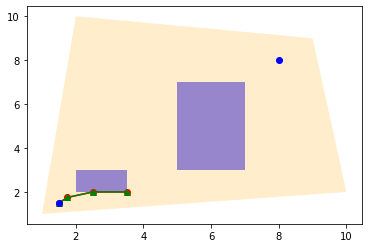


Optimization complete 1.
Solution found!


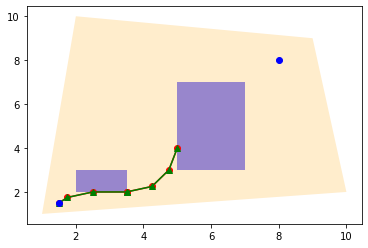


Optimization complete 2.
Solution found!


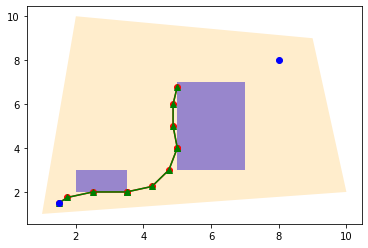


Optimization complete 3.
Solution found!


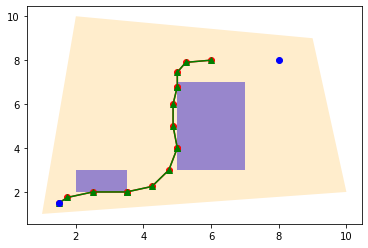


Optimization complete 4.
Solution found!


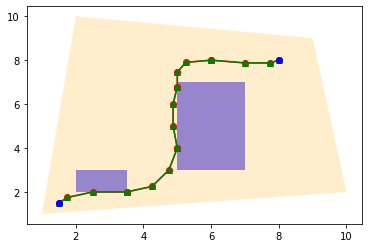

In [7]:
# Distância mínima do destino
EPSILON = 1E-5
DATA_SIZE = 100
STD_DEVIATION = 0.0

# Parâmetros RHC
current_state = START.copy()

number_of_it = 0

state_data_opt = np.zeros((VAR_STATE, DATA_SIZE))
state_data_model = np.zeros((VAR_STATE, DATA_SIZE))

error = float('inf')

while(error > EPSILON):

  # Restrição de posição inicial
  initial_x_constr.rhs   = current_state['x']
  initial_y_constr.rhs   = current_state['y']
  initial_V_x_constr.rhs = current_state['V_x']
  initial_V_y_constr.rhs = current_state['V_y']

  mdl.update()

  # -------------------
  # OPTIMIZE
  # -------------------
  mdl.optimize()

  print('')
  print('Optimization complete %d.' % number_of_it)
  if mdl.SolCount == 0:
    print('No solution found, optimization %d status = %d' % (number_of_it, mdl.Status))
    break
  else:
    print('Solution found!')
    
    error = mdl.ObjVal

    state_model = model_simulation([x[INIT].x, y[INIT].x, V_x[INIT].x, V_y[INIT].x], 
                                   [[F_x[i].x for i in range(TIMES - 1)], 
                                   [F_y[i].x for i in range(TIMES - 1)]], 
                                   STD_DEVIATION)

    # Get current state
    current_state['x']   = state_model[0, END]
    current_state['y']   = state_model[1, END]
    current_state['V_x'] = state_model[2, END]
    current_state['V_y'] = state_model[3, END]

    # Store data
    for i in range(TIMES):
      state_data_opt[0, number_of_it * TIMES + i]   = x[i].x
      state_data_opt[1, number_of_it * TIMES + i]   = y[i].x
      state_data_model[0, number_of_it * TIMES + i] = state_model[0, i]
      state_data_model[1, number_of_it * TIMES + i] = state_model[1, i]

    # -------------------
    # PLOT
    # -------------------

    fig = plt.figure()
    ax = fig.gca()

    path = [[
          # Objeto 1
          [2.,   2.],
          [2.,   3.],
          [3.5,  3.],
          [3.5,  2.]
        ],
        [
          # Objeto 2
          [5.,   3.],
          [5.,   7.],
          [7.,   7.],
          [7.,   3.]
        ],
        [
          # Região
          [1.,   1.],
          [2.,  10.],
          [9.,   9.],
          [10.,  2.]]]
    
    ax.add_patch(patches.Polygon(path[0], facecolor='blue', alpha=.5))
    ax.add_patch(patches.Polygon(path[1], facecolor='blue', alpha=.5))
    ax.add_patch(patches.Polygon(path[2], facecolor='orange', alpha=.2))


    plt.plot(
      state_data_opt[0, INIT:number_of_it * TIMES + TIMES],
      state_data_opt[1, INIT:number_of_it * TIMES + TIMES],
      '-ro'
    ) 
    plt.plot(
      state_data_model[0, INIT:number_of_it * TIMES + TIMES],
      state_data_model[1, INIT:number_of_it * TIMES + TIMES],
      '-g^'
    ) 

    plt.plot(GOAL['x'],  GOAL['y'],'bo') 
    plt.plot(START['x'], START['y'],'bo') 
    plt.show()

    number_of_it += 1